# Exercise 3 - CNNs, ResNets and LR-Scheduling

## General information
* Deep Learning – Winter term 2021/22
* Instructor: Alexander Ecker
* Tutors: Max Burg, Laura Pede
* Due date: **Tue, 07. Dec 21, at noon**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

### Important submission instructions

- **You need to answer all questions in written form!**
- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient
- Do not change the cells which are marked as "Do not change", similarly write your solution into the marked cells.

### Imports

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from google.colab import drive
import sys

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Colab (which is recommended) you have to mount the drive first and create a path to your python module.

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [25]:
# TODO import utils.py
drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/Colab/utils')
import utils as ut

Mounted at /content/drive


## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [26]:
# TODO define device
device = ut.get_device()

cuda available: True ; cudnn available: True ; num devices: 1
Using device Tesla K80


In [27]:
data_dir = 'data'
batch_size = 256

# TODO grab data, generate split, init data loaders
trainset, testset, mean, std = ut.grab_data(data_dir = data_dir, num_cpus=1)
trainset, valset = ut.generate_train_val_data_split(trainset, split_seed=42, val_frac=0.2)
trainloader, valloader, testloader = ut.init_data_loaders(trainset, valset, testset, batch_size=1024, num_cpus=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [28]:
# TODO define loss function
loss_function = nn.CrossEntropyLoss()

In [29]:
# shape of dataset
trainset.dataset[0][0].shape

torch.Size([3, 32, 32])

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

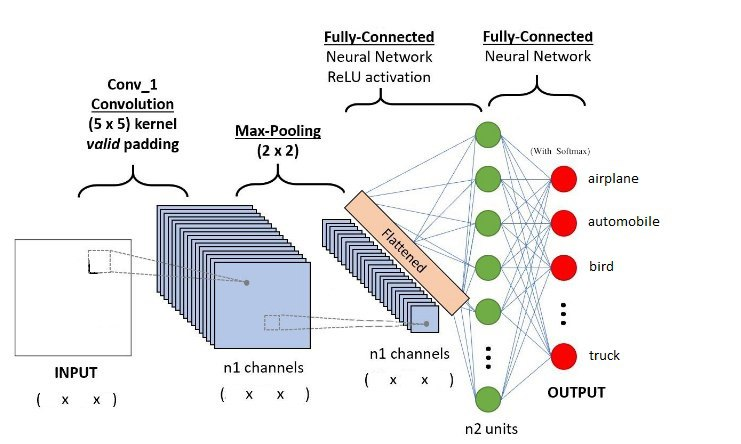

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What are the values for n1 and n2?
- What is the number of parameters for conv_1?

**Your answers here**

input dimensions: 3 x 32 x 32<br>
feature map dimensions: 32 x 28 x 28<br>
dimensions after pooling: 32 x 14 x 14<br>
value n1: 32<br>
value n2: 512<br>
number of parameters for conv_1: 3 * 5 * 5 * 32<br>
number of parameters first fully connected layer: 32 * 14 * 14 * 512 + 512<br>
number of parameters second fully connected layer: 512 * 10 + 10


In [30]:
class ConvNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 32, num_classes = 10, img_width = 32):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(14 * 14 * 32, 512)
        self.layer2 = nn.Linear(512, 10)
        self.pooling = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 5, padding="valid")

    def forward(self, x):
        x = self.conv(x)
        x = self.pooling(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

Finished training after 152 seconds.


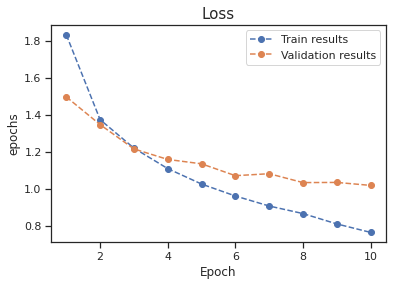

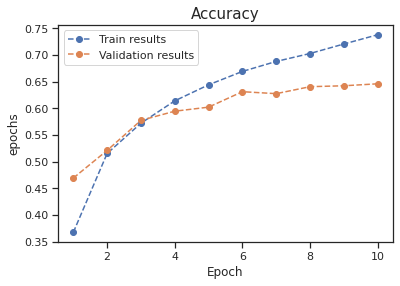

overall highest accuracy in epoch 9, value: 0.646
overall lowest loss in epoch 9, value: 1.0191872656345367


In [31]:
# TODO train and plot

model = ConvNet()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

result = ut.run_training(model, optimizer, loss_function, device, 10, 
                      trainloader, valloader, early_stopper=None, verbose=True)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = result
ut.plot("Loss", "epochs", train_losses, val_losses, yscale='linear')
ut.plot("Accuracy", "epochs", train_accs, val_accs, yscale='linear')
ut.diag(val_accs, val_losses)

#### **TODO**
Compare results to MLP. What can you observe?

It is already better on the test set than the best MLP model we achieved.

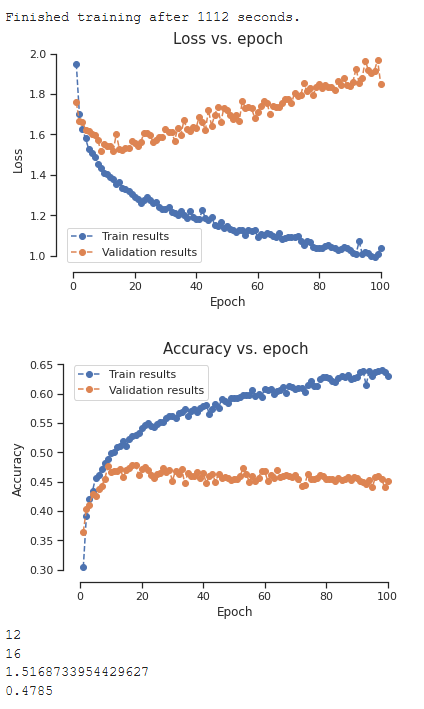

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 932 seconds.


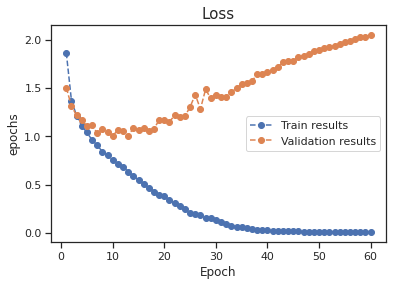

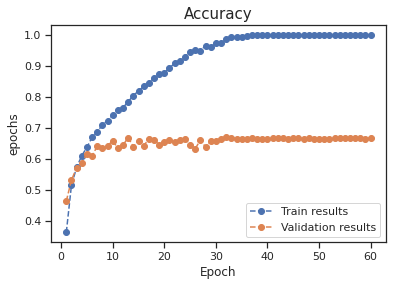

overall highest accuracy in epoch 31, value: 0.6691
overall lowest loss in epoch 12, value: 0.9998192131519318


In [32]:
# TODO train and plot

model = ConvNet()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

result = ut.run_training(model, optimizer, loss_function, device, 60, 
                      trainloader, valloader, early_stopper=None, verbose=True)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = result
ut.plot("Loss", "epochs", train_losses, val_losses, yscale='linear')
ut.plot("Accuracy", "epochs", train_accs, val_accs, yscale='linear')
ut.diag(val_accs, val_losses)

#### **Questions**
- Why is that not an optimal model?<br>

The final model after 60 epochs of training is highly overfitted. On the training set, the model perfectly predicts the labels while the validation accuracy keeps decreasing towards the end of training.

- What could be improved?

We could include an early stopper.

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

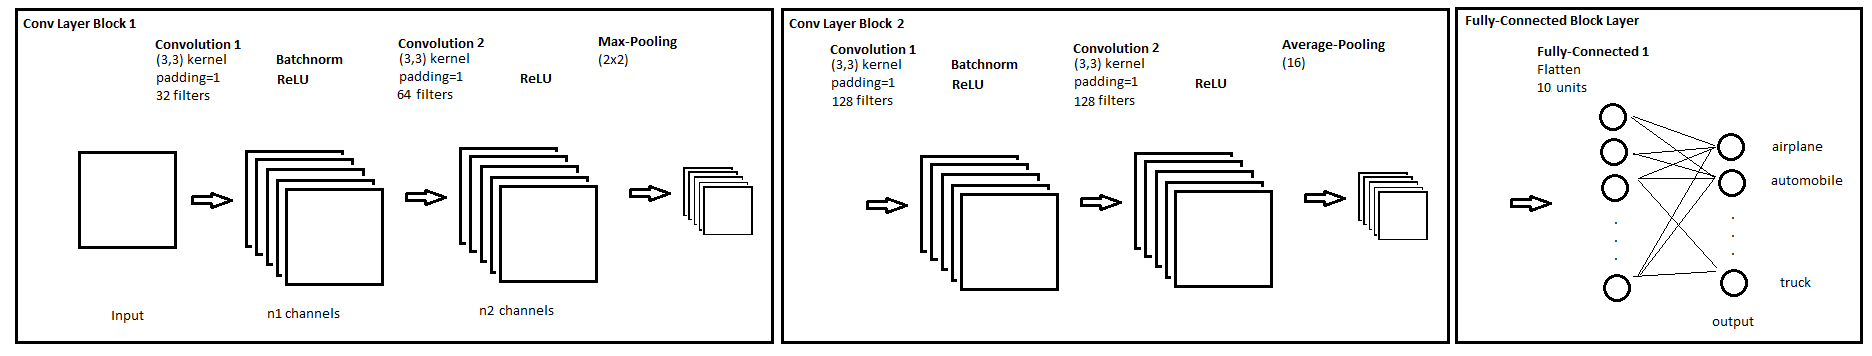

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?

Padding means (potentially) adding layers around the edges of the input. Valid padding adds no layers around the input. Same padding adds as many layers around the edges that after applying the kernel the output size is the same as the input size. Usually the layers added are zeros but there is also, for example, circular padding which adds the values from the other edge of the input.

- What does padding=1 mean in the case of the network displayed above?

Padding=1 means that we add one layer around the input size such that after applying a 3x3 kernel we get the same output size.

- What are the dimensions of the feature maps after the 1. conv layer?

Assuming that the pictures are still 32 x 32, we get 64 x 16 x 16 as the output since we have same padding.

- What are the dimensions of the feature maps after the 2. conv layer?

128 x 4 x 4

- What ist the receptive field size after the first two convolutions?

It is 5 x 5 after the first convolutions.
After the first two convolutional layers, it is 20x20

- What is the value for the in_features for the fully-connected layer?

value of in_features is 128

- What is the number of parameters of *Conv Layer block 1*?

3 * 3 * 3 * 32 + 32 * 3 * 3 * 64

In [33]:
class ConvNet2(nn.Module):
    def __init__(self):

        super().__init__()
        self.flatten = nn.Flatten()
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding="same")
        self.maxpool = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding="same")
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding="same")
        self.avgpool = nn.AvgPool2d(4)
        self.out = nn.Linear(128 * 4  * 4, 10)
        
    def forward(self, x):
        
        # block 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        
        x = self.maxpool(x)
        
        # block 2
        x = self.conv3(x)
        x = self.relu(x)
        x = self.batchnorm3(x)

        x = self.conv4(x)
        x = self.relu(x)

        x = self.avgpool(x)
        
        # out 
        x = self.flatten(x)
        x = self.out(x)
        
        return x

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results<br>
We used a learning rate of 0.001 instead since a learning rate of 0.1 did not work out at all. The net is more precise on the test set since it has multiple convolutional layers that allow for more fine tuned features that detect the classes better

Finished training after 824 seconds.


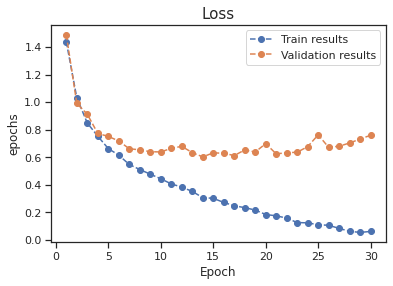

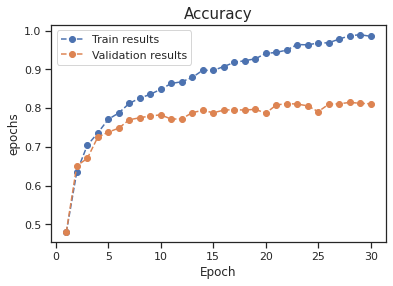

overall highest accuracy in epoch 27, value: 0.8148
overall lowest loss in epoch 13, value: 0.6022298872470856


In [34]:
# TODO train and plot

model = ConvNet2()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

result = ut.run_training(model, optimizer, loss_function, device, 30, 
                      trainloader, valloader, early_stopper=None, verbose=True)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = result
ut.plot("Loss", "epochs", train_losses, val_losses, yscale='linear')
ut.plot("Accuracy", "epochs", train_accs, val_accs, yscale='linear')
ut.diag(val_accs, val_losses)

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

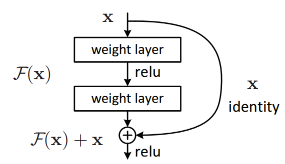

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Your answers here**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

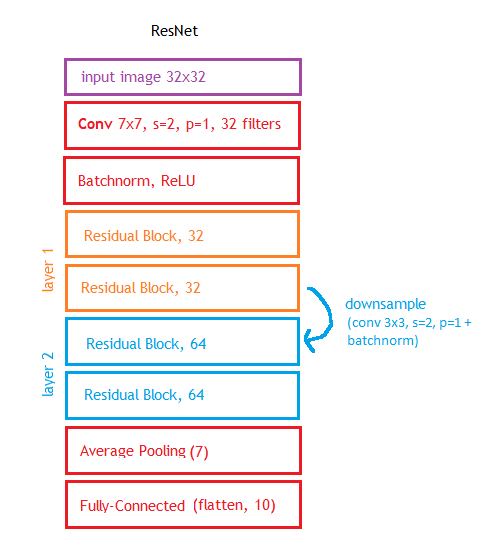 
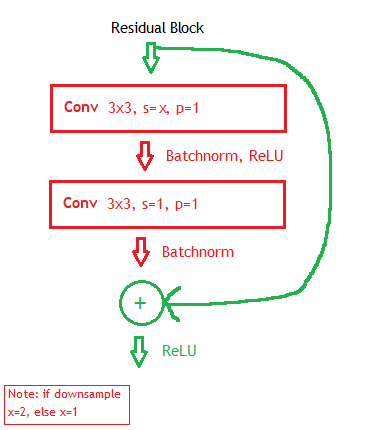

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [35]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):

        super().__init__()

        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = 3, padding=1, stride=1)
        self.downsample = nn.Conv2d
        self.stride = stride
        self.downsample = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=2), nn.BatchNorm2d(64))

    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.batchnorm(out)
        
        if self.stride == 2:
            x = self.downsample(x)
        
        out += x

        return out

In [36]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size = 7, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.resblock1 = ResidualBlock(in_channels=32, out_channels=32, stride=1)
        self.resblock2_1 = ResidualBlock(in_channels=32, out_channels=64, stride=2)
        self.resblock2_2 = ResidualBlock(in_channels=64, out_channels=64, stride=1)
        self.avg_pool1 = nn.AvgPool2d(7)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64, 10)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.resblock1(x)
        x = self.relu(x)
        x = self.resblock1(x)
        x = self.relu(x)
        x = self.resblock2_1(x)
        x = self.relu(x)
        x = self.resblock2_2(x)
        x = self.relu(x)


        x = self.avg_pool1(x)
        x = self.flatten(x)
        x = self.linear(x)
        return x

Finished training after 506 seconds.


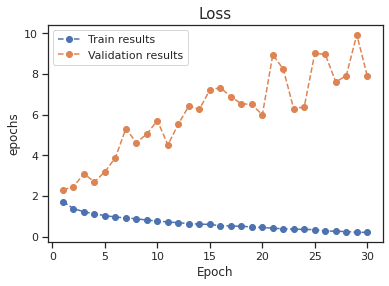

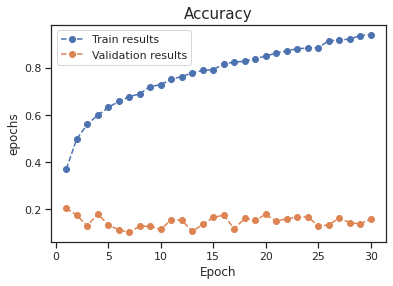

overall highest accuracy in epoch 0, value: 0.2055
overall lowest loss in epoch 0, value: 2.3010245323181153


In [37]:
# TODO train and plot

model = ResNet()
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

result = ut.run_training(model, optimizer, loss_function, device, 30, 
                      trainloader, valloader, early_stopper=None, verbose=True)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = result
ut.plot("Loss", "epochs", train_losses, val_losses, yscale='linear')
ut.plot("Accuracy", "epochs", train_accs, val_accs, yscale='linear')
ut.diag(val_accs, val_losses)

In [38]:
x = 1

In [ ]:
# TODO train and plot
%debug

> <ipython-input-18-8cbf1328adce>(23)forward()
     21 
     22         if self.stride == 2:
---> 23             x = self.downsample(x)
     24 
     25         out += x



#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [ ]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

In [ ]:
# TODO train and plot with step size 1, gamma 0.1

In [ ]:
# TODO train and plot with step size 1, gamma 0.9

#### **TODO** 

Use the learning rate schedule as described in the ResNet paper (https://arxiv.org/pdf/1512.03385.pdf). Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

In [ ]:
# TODO train and plot with scheduling, optimizer, lr as in the paper.

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [ ]:
# TODO train and plot

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [ ]:
# TODO do transfer learning with resnet on cifar10